In [25]:
import pandas as pd

# Caminho do arquivo
caminho = 'dados/transacoes_simuladas.csv'

# Ler o CSV (usando o mesmo separador que usamos ao criar — ";")
df = pd.read_csv(caminho, sep=';')

# Exibir as 5 primeiras linhas
print(df.head())

# Verificar informações gerais do DataFrame
print("\nInformações do DataFrame:")
print(df.info())

      tipo               descricao    valor        data    categoria
0  despesa   Despesa referente a 4  6989.67  2025-01-14      compras
1  despesa   Despesa referente a 9  3897.88  2025-03-31   transporte
2  despesa   Despesa referente a 4  8920.05  2025-02-23  alimentação
3  receita  Receita referente a 10  2039.33  2025-08-30      aluguel
4  despesa   Despesa referente a 8  4617.15  2025-07-04     educação

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tipo       100 non-null    object 
 1   descricao  100 non-null    object 
 2   valor      100 non-null    float64
 3   data       100 non-null    object 
 4   categoria  100 non-null    object 
dtypes: float64(1), object(4)
memory usage: 4.0+ KB
None


In [26]:
import pandas as pd
from datetime import datetime

# garanta colunas normalizadas
df.columns = [c.strip().lower() for c in df.columns]

# 1) limpar e converter a coluna 'data' de forma robusta
def _parse_data(s):
    if pd.isna(s):
        return pd.NaT
    s = str(s).strip()
    # tente alguns formatos comuns
    for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y", "%Y/%m/%d"):
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            pass
    # último recurso: deixe o pandas tentar
    try:
        return pd.to_datetime(s, dayfirst=True, errors="coerce")
    except Exception:
        return pd.NaT

df["data"] = df["data"].apply(_parse_data)

# 2) cheque se deu certo
print("dtype de df['data']:", df["data"].dtype)
print("datas inválidas (NaT):", df["data"].isna().sum())

# Saldo mensal
df["ano_mes"] = df["data"].dt.to_period("M")
saldo_mensal = (
    df.groupby(["ano_mes", "tipo"])["valor"]
    .sum()
    .unstack(fill_value=0)
)
saldo_mensal["saldo"] = saldo_mensal["receita"] - saldo_mensal["despesa"]

print("\n📆 Saldo Mensal:")
print(saldo_mensal)

dtype de df['data']: datetime64[ns]
datas inválidas (NaT): 0

📆 Saldo Mensal:
tipo      despesa   receita    saldo
ano_mes                             
2024-11   9209.21  18560.39  9351.18
2024-12  17643.85  25542.92  7899.07
2025-01  23333.59  18360.87 -4972.72
2025-02  23937.77  20471.77 -3466.00
2025-03  29611.35  31769.00  2157.65
2025-04  11977.94  16574.79  4596.85
2025-05   2400.04  11214.08  8814.04
2025-06  21379.91  16874.89 -4505.02
2025-07  21223.41  25614.32  4390.91
2025-08  14656.36  20081.05  5424.69
2025-09  29064.26  38178.10  9113.84
2025-10  31587.22  29472.07 -2115.15


Receitas: R$ 272714.25 | Despesas: R$ 236024.91 | Saldo: R$ 36689.34


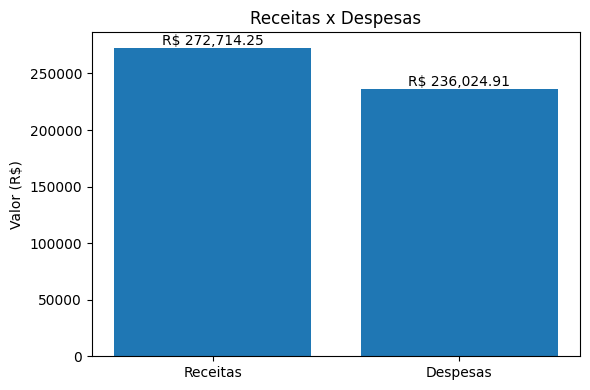

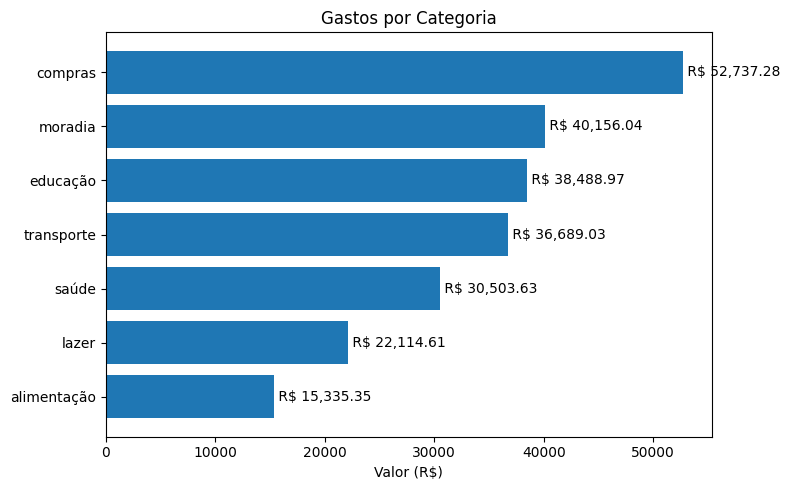

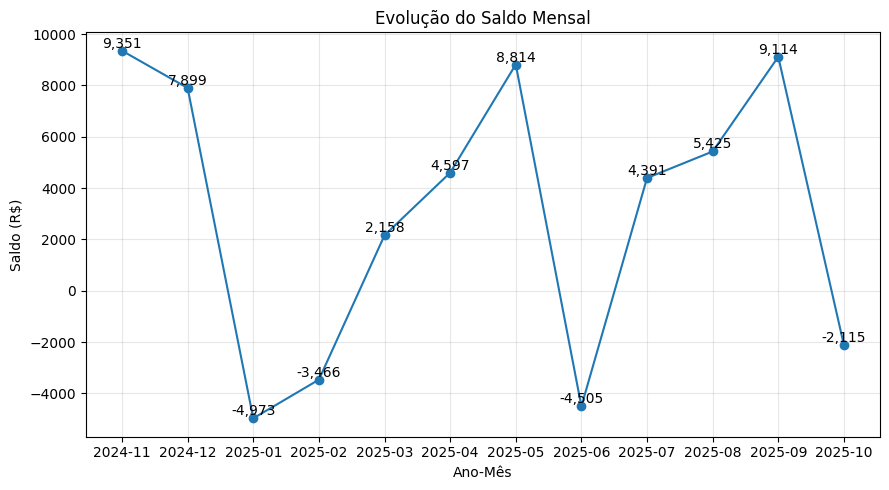

In [27]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0) Preparos: totais e tabelas auxiliares (em cima do df limpo)
# ------------------------------------------------------------------
# normaliza tipo/categoria se ainda não estiver
df["tipo"] = df["tipo"].str.lower().str.strip()
df["categoria"] = df.get("categoria", "").astype(str).str.strip().replace({"": "Sem categoria"})

# totais simples
total_receitas = df.loc[df["tipo"] == "receita", "valor"].sum()
total_despesas = df.loc[df["tipo"] == "despesa", "valor"].sum()
saldo_atual = total_receitas - total_despesas
print(f"Receitas: R$ {total_receitas:.2f} | Despesas: R$ {total_despesas:.2f} | Saldo: R$ {saldo_atual:.2f}")

# gastos por categoria (apenas despesas)
gastos_categoria = (
    df[df["tipo"] == "despesa"]
    .groupby("categoria")["valor"]
    .sum()
    .sort_values(ascending=True)  # ascending=True para facilitar o barh (cresce pra cima)
)

# saldo mensal
df["ano_mes"] = df["data"].dt.to_period("M")
saldo_mensal = (
    df.pivot_table(index="ano_mes", columns="tipo", values="valor", aggfunc="sum", fill_value=0)
    .sort_index()
)

# garante colunas mesmo que não existam no período
for col in ["receita", "despesa"]:
    if col not in saldo_mensal.columns:
        saldo_mensal[col] = 0.0

saldo_mensal["saldo"] = saldo_mensal["receita"] - saldo_mensal["despesa"]

# ------------------------------------------------------------------
# 1) Gráfico: Receitas x Despesas (barra)
# ------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.bar(["Receitas", "Despesas"], [total_receitas, total_despesas])
plt.title("Receitas x Despesas")
plt.ylabel("Valor (R$)")
for i, v in enumerate([total_receitas, total_despesas]):
    plt.text(i, v, f"R$ {v:,.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2) Gráfico: Gastos por Categoria (barra horizontal)
# ------------------------------------------------------------------
if not gastos_categoria.empty:
    plt.figure(figsize=(8, 5))
    plt.barh(gastos_categoria.index, gastos_categoria.values)
    plt.title("Gastos por Categoria")
    plt.xlabel("Valor (R$)")
    # anotações nos rótulos
    for y, v in enumerate(gastos_categoria.values):
        plt.text(v, y, f" R$ {v:,.2f}", va="center")
    plt.tight_layout()
    plt.show()
else:
    print("Sem despesas para exibir por categoria.")

# ------------------------------------------------------------------
# 3) Gráfico: Evolução do Saldo Mensal (linha)
# ------------------------------------------------------------------
if not saldo_mensal.empty:
    # converte Period para string para aparecer bonito no eixo x
    x_labels = saldo_mensal.index.astype(str)

    plt.figure(figsize=(9, 5))
    plt.plot(x_labels, saldo_mensal["saldo"], marker="o")
    plt.title("Evolução do Saldo Mensal")
    plt.xlabel("Ano-Mês")
    plt.ylabel("Saldo (R$)")
    plt.grid(True, alpha=0.3)
    # rótulos nos pontos
    for x, y in zip(range(len(x_labels)), saldo_mensal["saldo"].values):
        plt.text(x, y, f"{y:,.0f}", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()
else:
    print("Sem dados para saldo mensal.")